# SEI Growth Comparison: First vs Second cycles

> Reproduces Figure 5 from the [paper](https://iopscience.iop.org/article/10.1149/1945-7111/ad8548), comparing Solid Electrolyte Interphase (SEI) growth in electron-limited models across two formation cycles.

As usual, first step is to import PyBaMM into the notebook:

In [9]:
import pybamm

> Define the charging/discharging protocol for formation cycling at low C-rate

In [10]:

no_cycles = 2
exp = pybamm.Experiment(
    [("Charge at C/20 until 4.2 V",
      "Rest for 5 hours",
      "Discharge at C/20 until 2.5 V",
      "Rest for 5 hours",
      )]* no_cycles )


> Parameter set "Chen2020" from PyBaMM was used, with modifications or non exsistng parameetrs to key SEI parameters for four electron related SEI models electron migration, interstitial diffusion, tunnelling , and   VonKolzenberg2020

In [11]:
param = pybamm.ParameterValues("Chen2020")
param.update({
    'Initial SEI thickness [m]': 1e-12,
    'SEI kinetic rate constant [m.s-1]': 7.0e-13,
    'SEI solvent diffusivity [m2.s-1]': 1e-14,
    'Bulk solvent concentration [mol.m-3]': 4541.0,
    'SEI electron conductivity [S.m-1]': 8.95e-15,
    'SEI lithium ion conductivity [S.m-1]': 1.0e-7,
    'SEI lithium interstitial diffusivity [m2.s-1]': 1e-20,
    'Lithium interstitial reference concentration [mol.m-3]': 1000,
    'Tunneling barrier factor [m-1]': 1/2.0e-9,
    'Tunneling distance for electrons [m]': 0,
    'SEI reaction exchange current density [A.m-2]': 0.0003,
    'SEI open-circuit potential [V]': 0.4,
}, check_already_exists=False)



> Create four SEI models to compare, each using SPM (Single Particle Model) with uniform particle profile and CasADi solver starting at 0% SOC, differing only in SEI options

In [12]:
sei_options = [ "electron-migration limited", "interstitial-diffusion limited", "tunnelling limited", "VonKolzenberg2020"]

models = [pybamm.lithium_ion.SPM({"particle": "uniform profile",
                                  "SEI": sei_option}) for sei_option in sei_options]


sims = [pybamm.Simulation(model, parameter_values=param,
                          experiment=exp) for  model in models]
sols = [sim.solve(initial_soc=0) for sim in sims]

### Visualize SEI formation behavior across different models:
> 
  - Left (a): SEI layer growth in nm
  - Right (b): Irreversible current density with magnified inset
  - Both subplots include vertical guides and horizontal arrows to denote charging, discharging, and rest periods

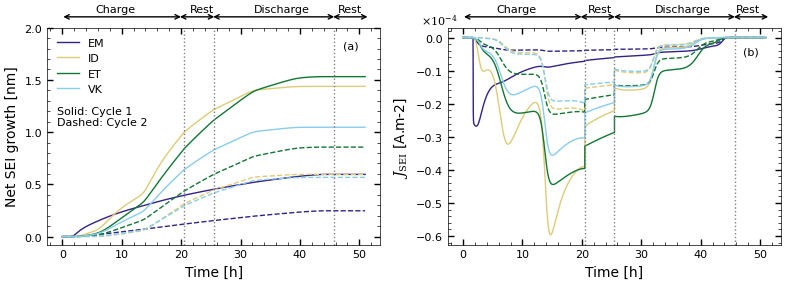

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from style_figs import set_plotting_format

set_plotting_format("paper")

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True)

label_models = ['EM','ID','ET',"VK"]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
line_styles = ['-', '--']

# First plot
for index, sol in enumerate(sols):
    color = colors[(1+index) % len(colors)]
    for cycle in range(no_cycles):
        t_min = np.min(sol.cycles[cycle]["Time [h]"].entries)
        t = sol.cycles[cycle]["Time [h]"].entries - t_min
        L_min = np.min(sol.cycles[cycle]['X-averaged negative total SEI thickness [m]'].entries)
        L_sei = (sol.cycles[cycle]['X-averaged negative total SEI thickness [m]'].entries - L_min) * 1e9
        if (cycle == 0):
            axes[0].plot(t, L_sei,  label=label_models[index], color=color, linestyle=line_styles[cycle % 2])
        else:
            axes[0].plot(t, L_sei,  color=color, linestyle=line_styles[cycle % 2])

# Second plot
for index, sol in enumerate(sols):
    color = colors[(1+index) % len(colors)]
    for cycle in range(no_cycles):
        t_min = np.min(sol.cycles[cycle]["Time [h]"].entries)
        t = sol.cycles[cycle]["Time [h]"].entries - t_min
        J_sei_last = sol.cycles[cycle]['X-averaged negative electrode SEI interfacial current density [A.m-2]'].entries[0]
        J_sei = sol.cycles[cycle]['X-averaged negative electrode SEI interfacial current density [A.m-2]'].entries - J_sei_last * 0
        axes[1].plot(t, J_sei * 1e4, color=color, linestyle=line_styles[cycle % 2])

# Set up main axes[0] properties
axes[0].set_yticks(np.linspace(0, 2, 5))
axes[0].set_xlabel("Time [h]")
axes[0].set_ylabel("Net SEI growth [nm]")
axes[0].legend()
axes[0].text(0.03, 0.55, 'Solid: Cycle 1\nDashed: Cycle 2',transform=axes[0].transAxes)

# Add vertical dotted lines to show charging, discharging and rest periods for subplot 0
axes[0].axvline(x=20.5, color='grey', linestyle=':', linewidth=1)
axes[0].axvline(x=25.5, color='grey', linestyle=':', linewidth=1)
axes[0].axvline(x=45.7, color='grey', linestyle=':', linewidth=1)

# Add phase labels for subplot 0
axes[0].text(9, 2.15, 'Charge', ha='center')
axes[0].text(23.5, 2.15, 'Rest', ha='center')
axes[0].text(37, 2.15, 'Discharge', ha='center')
axes[0].text(48.5, 2.15, 'Rest', ha='center')
axes[0].text(48.5, 1.8, '(a)', ha='center')

# Add horizontal arrows at the top of subplot 0
axes[0].annotate('', xy=(0.04, 1.05), xytext=(0.41, 1.05), xycoords='axes fraction', textcoords='axes fraction', arrowprops={'arrowstyle': '<->', 'color': 'black'})
axes[0].annotate('', xy=(0.39, 1.05), xytext=(0.51, 1.05), xycoords='axes fraction', textcoords='axes fraction', arrowprops={'arrowstyle': '<->', 'color': 'black'})
axes[0].annotate('', xy=(0.49, 1.05), xytext=(0.87, 1.05), xycoords='axes fraction', textcoords='axes fraction', arrowprops={'arrowstyle': '<->', 'color': 'black'})
axes[0].annotate('', xy=(0.85, 1.05), xytext=(0.97, 1.05), xycoords='axes fraction', textcoords='axes fraction', arrowprops={'arrowstyle': '<->', 'color': 'black'})



# Add vertical dotted lines to show charging, discharging and rest periods for subplot 1
axes[1].axvline(x=20.5, color='grey', linestyle=':', linewidth=1)
axes[1].axvline(x=25.5, color='grey', linestyle=':', linewidth=1)
axes[1].axvline(x=45.7, color='grey', linestyle=':', linewidth=1)

# Add phase labels for subplot 1
axes[1].text(9, 0.077, 'Charge', ha='center')
axes[1].text(23, 0.077, 'Rest', ha='center')
axes[1].text(37, 0.077, 'Discharge', ha='center')
axes[1].text(48,0.077, 'Rest', ha='center')
axes[1].text(48.5, -0.05, '(b)', ha='center')

# Add horizontal arrows at the top of subplot 1
axes[1].annotate('', xy=(0.04, 1.05), xytext=(0.41, 1.05), xycoords='axes fraction', textcoords='axes fraction', arrowprops={'arrowstyle': '<->', 'color': 'black'})
axes[1].annotate('', xy=(0.39, 1.05), xytext=(0.51, 1.05), xycoords='axes fraction', textcoords='axes fraction', arrowprops={'arrowstyle': '<->', 'color': 'black'})
axes[1].annotate('', xy=(0.49, 1.05), xytext=(0.87, 1.05), xycoords='axes fraction', textcoords='axes fraction', arrowprops={'arrowstyle': '<->', 'color': 'black'})
axes[1].annotate('', xy=(0.85, 1.05), xytext=(0.97, 1.05), xycoords='axes fraction', textcoords='axes fraction', arrowprops={'arrowstyle': '<->', 'color': 'black'})


axes[1].set_xlabel("Time [h]")
axes[1].set_ylabel(r"$J_\mathrm{SEI}$ [A.m-2] ")
axes[1].text(-0.08, 1.07, r'$\times 10^{-4}$', transform=axes[1].transAxes, verticalalignment='top')


plt.tight_layout()
plt.savefig("figs/electron_limited.png", dpi=300)

In [14]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Ferran Brosa Planella and W. Dhammika Widanage. Systematic derivation of a Single Particle Model with Electrolyte and Side Reactions (SPMe+SR) for degradation of lithium-ion batteries. Submitted for publication, ():, 2022. doi:.
[3] Von DAG Bruggeman. Berechnung verschiedener physikalischer konstanten von heterogenen substanzen. i. dielektrizitätskonstanten und leitfähigkeiten der mischkörper aus isotropen substanzen. Annalen der physik, 416(7):636–664, 1935.
[4] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020